In [ ]:
!git clone https://github.com/YutongLei2020/CS-172B-Project.git
%cd ./CS-172B-Project/

Cloning into 'CS-172B-Project'...
remote: Enumerating objects: 34081, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 34081 (delta 10), reused 3 (delta 1), pack-reused 34058
Receiving objects: 100% (34081/34081), 58.04 MiB | 27.66 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (35896/35896), done.
/content/CS-172B-Project


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
# gpuid = 0 # An index of which gpu to use. 
# os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ['CUDA_VISIBLE_DEVICES'] = "{}".format(gpuid) # (Empty) List of gpu indices that TF can see.
from keras import backend as K
import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l2
import load_images_colab

In [ ]:
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = load_images_colab.getDataset()

In [ ]:
# baseline 2_hidden layers fully connected
model = Sequential() 
model.add(Input(shape=(48,48,1)))
model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 256, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5)) # Including dropout layer helps avoid overfitting.
model.add(Dense(units=7 ,activation='softmax')) #output layer 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 48, 48, 512)       1024      
                                                                 
 dense_4 (Dense)             (None, 48, 48, 256)       131328    
                                                                 
 flatten_1 (Flatten)         (None, 589824)            0         
                                                                 
 dropout_1 (Dropout)         (None, 589824)            0         
                                                                 
 dense_5 (Dense)             (None, 7)                 4128775   
                                                                 
Total params: 4,261,127
Trainable params: 4,261,127
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer= Adam(learning_rate=0.01), 
    metrics=['accuracy']
)
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint(filepath = 'models/2_layers_fullyConnected_model', 
        save_freq = 'epoch' ,
        save_best_only = True,
        monitor = 'val_loss',
        mode ='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

callbacks = [ mcp_save,reduce_lr_loss]


In [ ]:
history = model.fit(X_train, Y_train,batch_size= 512,
                    epochs=50,verbose=1, validation_data=(X_validation, Y_validation),callbacks = callbacks)

Epoch 1/50
43/43 [==============================] - 32s 741ms/step - loss: 6.4371 - accuracy: 0.2228 - val_loss: 1.7696 - val_accuracy: 0.2686 - lr: 0.0100
Epoch 2/50
43/43 [==============================] - 29s 680ms/step - loss: 1.7401 - accuracy: 0.2976 - val_loss: 1.8229 - val_accuracy: 0.3128 - lr: 0.0100
Epoch 3/50
43/43 [==============================] - 29s 688ms/step - loss: 1.6903 - accuracy: 0.3370 - val_loss: 1.6912 - val_accuracy: 0.3340 - lr: 0.0100
Epoch 4/50
43/43 [==============================] - 28s 652ms/step - loss: 1.6776 - accuracy: 0.3423 - val_loss: 1.6726 - val_accuracy: 0.3461 - lr: 0.0100
Epoch 5/50
43/43 [==============================] - 28s 652ms/step - loss: 1.6650 - accuracy: 0.3460 - val_loss: 1.6827 - val_accuracy: 0.3465 - lr: 0.0100
Epoch 6/50
43/43 [==============================] - 28s 650ms/step - loss: 1.6666 - accuracy: 0.3460 - val_loss: 1.6706 - val_accuracy: 0.3471 - lr: 0.0100
Epoch 7/50
43/43 [==============================] - 30s 690ms/st

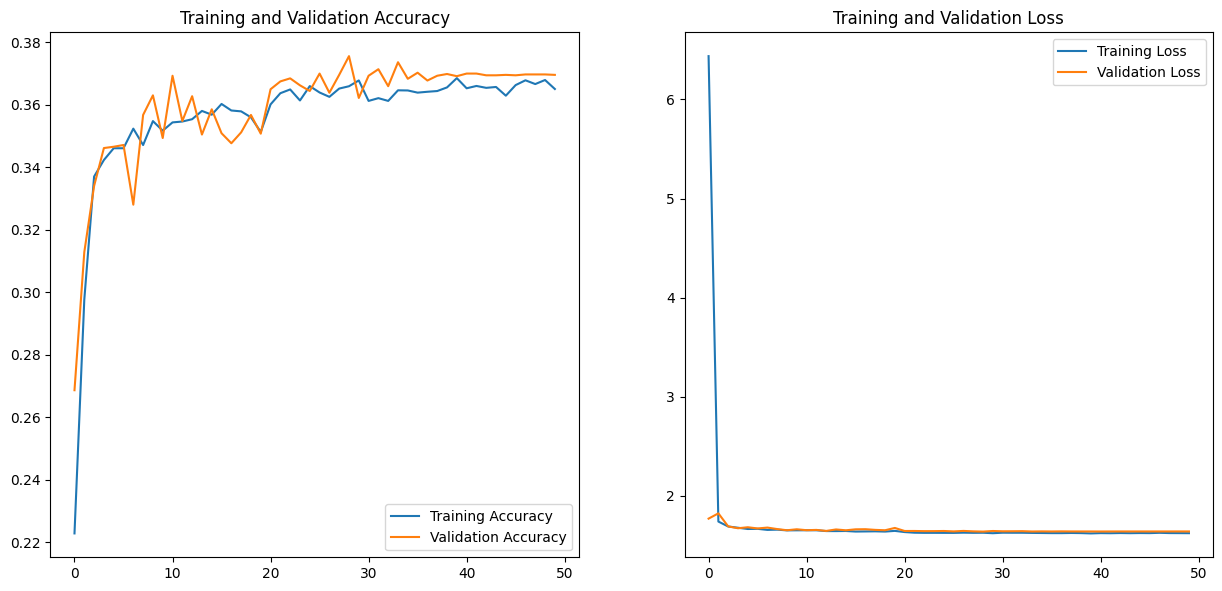

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# best model prediction on test data
del(model)
model = load_model('models/2_layers_fullyConnected_model')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

225/225 [==============================] - 4s 16ms/step


In [ ]:
Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each testing datapoint
prediction_accuracy = np.mean(Y_prediction==Y_test)
print("The accuracy on test data is: ", prediction_accuracy)

The accuracy on test data is:  0.3232098077458902


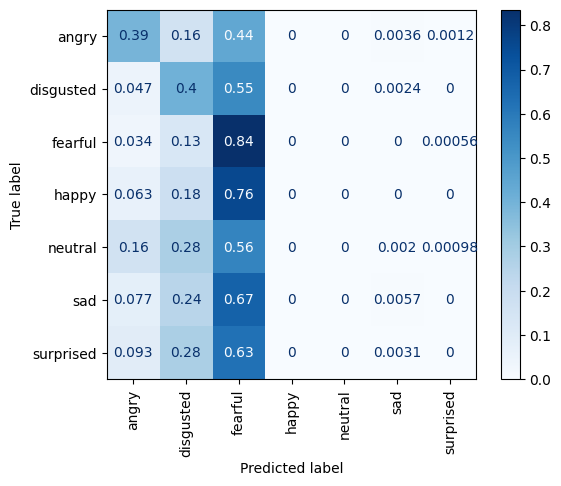

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
# confusion matrix
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
cm = confusion_matrix(Y_test, Y_prediction, normalize= 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = classes)
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)